# Tutorial: Perturbation simulation

In this tutorial we illustrate how the predictions from SCENIC+ can be utilized to simulate the effect of transcription factor perturbations.

Here, the predictions of SCENIC+ serve as a feature selection method. We will use the expression of transcription factors (TFs) as predictors for their target gene expression. For this a random forest regression model will be fitted for each gene with the expression of TFs which are predicted to regulate them by SCENIC+ as predictor for their target gene expression. After fitting the models we can alter the expression of a TF of choice and we can simulate a new gene expression matrix. This simulation is repeated for several iterations to simulate indirect effects. The simulated cells in this new matrix can be projected in an embedding of choice to visualize the effect of the perturbation.

<div class="alert alert-warning">

**Warning:**
In order to continue you need to have the python package `velocyto` installed.

</div>

In [ ]:
%pip install velocyto

In [5]:
import mudata
import os
import scanpy as sc
import anndata
import matplotlib
import matplotlib.pyplot as plt
import adjustText
import numpy as np
import pandas as pd

In [33]:
from scenicplus.simulation import (
    train_gene_expression_models,
    simulate_perturbation,
    plot_perturbation_effect_in_embedding
)

In [7]:
%matplotlib inline

In [8]:
data_dir = "/staging/leuven/stg_00002/lcb/sdewin/PhD/testing/new_scenicplus_mm_lines/Snakemake"

In [9]:
scplus_mdata = mudata.read(os.path.join(data_dir, "scplusmdata.h5mu"))

/lustre1/project/stg_00002/mambaforge/vsc33053/envs/scenicplus_development_tutorial/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/lustre1/project/stg_00002/mambaforge/vsc33053/envs/scenicplus_development_tutorial/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/lustre1/project/stg_00002/mambaforge/vsc33053/envs/scenicplus_development_tutorial/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/lustre1/project/stg_00002/mambaforge/vsc33053/envs/scenicplus_development_tutorial/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/lustre1/project/stg_00002/mamba

In [10]:
scplus_mdata

MuData object with n_obs × n_vars = 470 × 363087
  uns:	'direct_e_regulon_metadata', 'extended_e_regulon_metadata'
  6 modalities
    scRNA_counts:	470 x 18878
      obs:	'MMline'
    scATAC_counts:	470 x 343843
      obs:	'MMline'
    direct_gene_based_AUC:	470 x 104
    direct_region_based_AUC:	470 x 104
    extended_gene_based_AUC:	470 x 79
    extended_region_based_AUC:	470 x 79

In [11]:
eRegulon_gene_AUC = anndata.concat(
    [scplus_mdata["direct_gene_based_AUC"], scplus_mdata["extended_gene_based_AUC"]],
    axis = 1,
)
eRegulon_gene_AUC.obs = scplus_mdata.obs

In [12]:
eRegulon_gene_AUC

AnnData object with n_obs × n_vars = 470 × 183
    obs: 'scRNA_counts:MMline', 'scATAC_counts:MMline'

In [13]:
sc.pp.pca(eRegulon_gene_AUC)

In [14]:
color_dict_line = {
    'MM001': '#9A031E', 
    'MM011': '#C75146', 
    'MM031': '#FFA987',
    'MM074': '#222E50',
    'MM087': '#8BB174',
    'MM057': '#2A4849',
    'MM029': '#3E5641', 
    'MM047': '#59A96A',  
    'MM099': '#56E39F'}

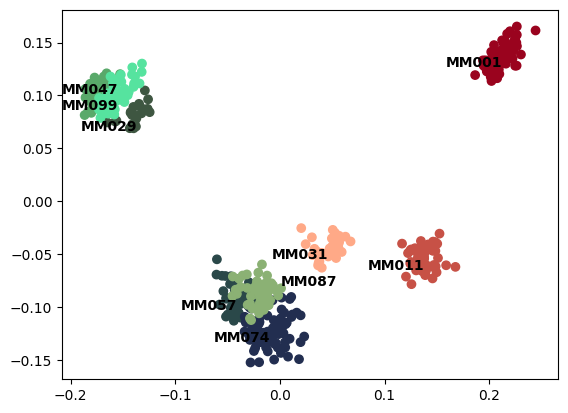

In [15]:
def plot_mm_line_pca(ax):
    texts = []
    # Plot PCA
    ax.scatter(
        eRegulon_gene_AUC.obsm["X_pca"][:, 0],
        eRegulon_gene_AUC.obsm["X_pca"][:, 1],
        color = [color_dict_line[line] for line in eRegulon_gene_AUC.obs["scRNA_counts:MMline"]]
    )
    # Plot labels
    for line in set(eRegulon_gene_AUC.obs["scRNA_counts:MMline"]):
        line_bc_idc = np.arange(len(eRegulon_gene_AUC.obs_names))[eRegulon_gene_AUC.obs["scRNA_counts:MMline"] == line]
        avg_x, avg_y = eRegulon_gene_AUC.obsm["X_pca"][line_bc_idc, 0:2].mean(0)
        texts.append(
            ax.text(
                avg_x,
                avg_y,
                line,
                fontweight = "bold"
            )
        )
    adjustText.adjust_text(texts)

fig, ax = plt.subplots()
plot_mm_line_pca(ax)

In [16]:
gene_tf_direct_extended = pd.concat(
    [
        scplus_mdata.uns["direct_e_regulon_metadata"][["Gene", "TF"]].drop_duplicates(),
        scplus_mdata.uns["extended_e_regulon_metadata"][["Gene", "TF"]].drop_duplicates()
    ]
).drop_duplicates()
gene_to_TF = gene_tf_direct_extended.groupby("Gene")["TF"].apply(lambda tfs: list(tfs)).to_dict()

In [17]:
gene_to_TF["ERBB3"]

['SOX10', 'SOX6', 'CTNNB1', 'SOX9']

In [31]:
# use a subset of genes, just so the notebook runs fast
genes_to_use = scplus_mdata.uns["direct_e_regulon_metadata"].sort_values("triplet_rank")["Gene"].iloc[0:5_000].drop_duplicates()

In [32]:
regressors = train_gene_expression_models(
    df_EXP = scplus_mdata["scRNA_counts"].to_df(),
    gene_to_TF = gene_to_TF,
    genes = genes_to_use,
)

100%|██████████| 2892/2892 [06:49<00:00,  7.07it/s]


In [34]:
perturbation_over_iter = simulate_perturbation(
    df_EXP = scplus_mdata["scRNA_counts"].to_df(),
    perturbation = {"SOX10": 0},
    keep_intermediate = True,
    n_iter = 5,
    regressors = regressors
)

In [49]:
perturbation_over_iter.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6])

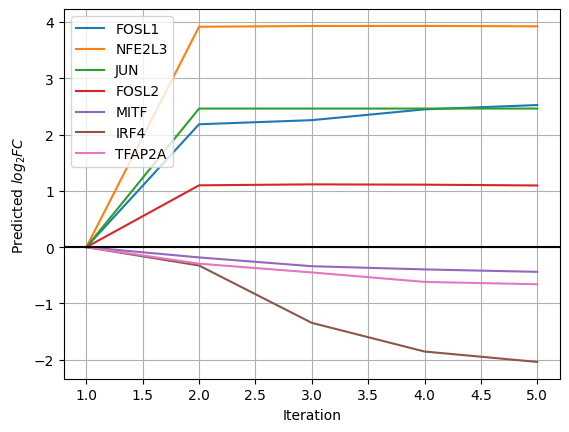

In [72]:
genes_to_show = ["FOSL1", "NFE2L3", "JUN", "FOSL2", "MITF", "IRF4", "TFAP2A"]
cell_line = "MM001"
fig, ax = plt.subplots()
baseline = perturbation_over_iter[0].groupby(eRegulon_gene_AUC.obs["scRNA_counts:MMline"]).mean().loc[cell_line, genes_to_show]
for gene in genes_to_show:
    ax.plot(
        np.arange(5) + 1,
        [
            np.log2(perturbation_over_iter[i].groupby(eRegulon_gene_AUC.obs["scRNA_counts:MMline"]).mean().loc[cell_line, gene] / baseline[gene])
            for i in np.arange(5) + 1
        ],
        label = gene
    )
ax.set_ylabel("Predicted $log{_2}FC$")
ax.set_xlabel("Iteration")
ax.legend()
ax.axhline(y = 0, color = "black")
ax.grid("gray")
ax.set_axisbelow(True)

2024-08-30 12:44:17,610 Perturbation INFO     Generating ranking based on perturbed matrix.
2024-08-30 12:44:18,171 Perturbation INFO     Scoring eRegulons.
2024-08-30 12:44:21,446 Perturbation INFO     Projecting perturbation effect in embedding
2024-08-30 12:44:26,974 Perturbation INFO     Calculating grid of arrows
2024-08-30 12:44:27,049 Perturbation INFO     Plotting


/lustre1/project/stg_00002/mambaforge/vsc33053/envs/scenicplus_development_tutorial/lib/python3.11/site-packages/scenicplus/simulation.py:232: RuntimeWarning: invalid value encountered in divide
  unitary_vectors /= np.linalg.norm(unitary_vectors, ord=2, axis=0)  # divide by L2


<AxesSubplot: >

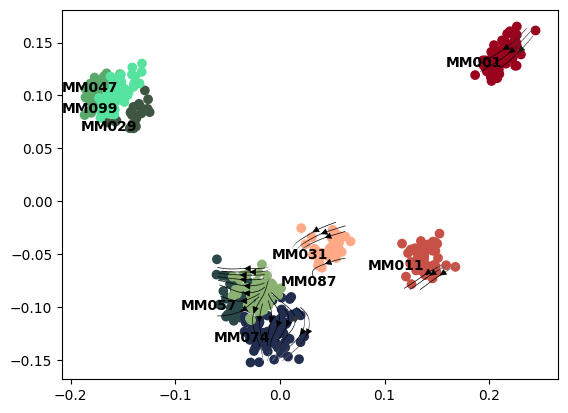

In [76]:
fig, ax = plt.subplots()
plot_mm_line_pca(ax)
plot_perturbation_effect_in_embedding(
    perturbed_matrix = perturbation_over_iter[5],
    original_matrix = perturbation_over_iter[0],
    embedding = eRegulon_gene_AUC.obsm["X_pca"][:, 0:2],
    AUC_kwargs = {},
    ax = ax,
    eRegulons = pd.concat(
        [
            scplus_mdata.uns["direct_e_regulon_metadata"],
            scplus_mdata.uns["extended_e_regulon_metadata"]
        ]
    ),
    n_cpu = 10
)